# TODO:

* Try without gradient clipping

In [1]:
import sys
sys.path.append("..")
import models
import policy_gradient_methods
import utils
import gymnasium as gym
import torch
import random

# Settings

In [2]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_EPISODES = 10000
GRAD_CLIP_VALUE = 100
GAMMA = 0.9
NN_HIDDEN_LAYER_SIZES = [16, 16]
RNG_SEED = 7
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("PyTorch device:", device)
torch.manual_seed(RNG_SEED)
random.seed(RNG_SEED)

PyTorch device: cpu


# REINFORCE

## Linear model

Average return per episode: 42.9173


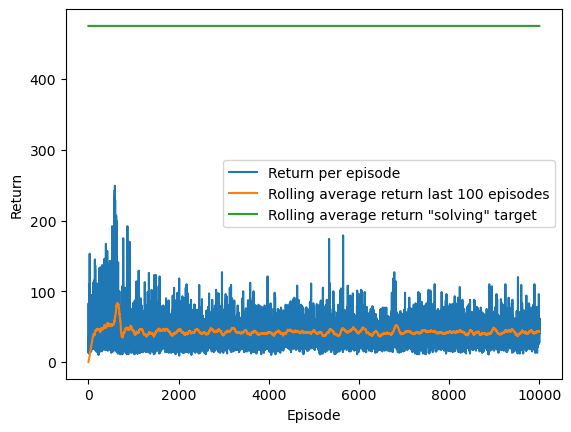

In [3]:
env = gym.make(ENVIRONMENT_ID)
policy_model = torch.nn.Sequential(
    torch.nn.Linear(env.observation_space.shape[0], env.action_space.n),
    torch.nn.Softmax(dim=0)
).to(device)
optimizer = torch.optim.SGD(policy_model.parameters(), lr=0.01)
returns, states, actions, rewards = policy_gradient_methods.train_episodic_reinforce(
    env, policy_model, optimizer, device, RNG_SEED, NUM_EPISODES, GAMMA, GRAD_CLIP_VALUE
)
utils.plot_returns(returns, env.spec.reward_threshold)

## Neural network model

Average return per episode: 89.8009


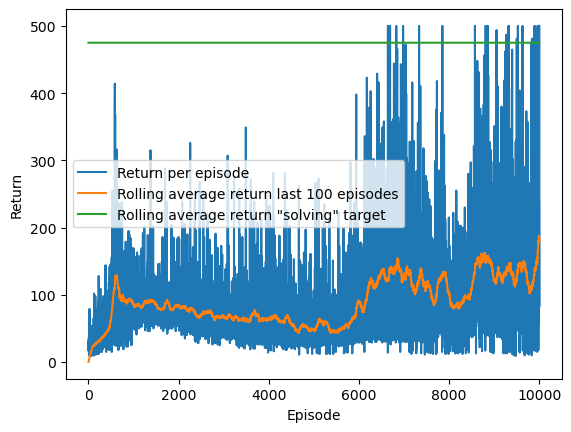

In [4]:
env = gym.make(ENVIRONMENT_ID)
policy_model = models.create_simple_nn(
    env.observation_space.shape[0],
    env.action_space.n,
    NN_HIDDEN_LAYER_SIZES,
    output_activation="softmax"
).to(device)
#optimizer = torch.optim.SGD(policy_model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(policy_model.parameters(), lr=0.001, amsgrad=True)
returns, states, actions, rewards = policy_gradient_methods.train_episodic_reinforce(
    env, policy_model, optimizer, device, RNG_SEED, NUM_EPISODES, GAMMA, GRAD_CLIP_VALUE
)
utils.plot_returns(returns, env.spec.reward_threshold)

# REINFORCE with baseline

## Linear model

## Neural network model